In [1]:

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import sys
from pathlib import Path
import sys
sys.path.append('.')
from utils.Descriptor import *
import os
import random
from utils.utils import *

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from keras import backend as K

2025-05-16 02:13:24.136478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 02:13:24.672768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747349004.875762     789 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747349004.931111     789 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 02:13:25.442696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Random setting
seed_value= 1
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)


I0000 00:00:1747349011.586496     789 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1404 MB memory:  -> device: 0, name: NVIDIA GeForce MX350, pci bus id: 0000:02:00.0, compute capability: 6.1


In [4]:

descripted = descriptor('Databases/Database.csv', 'Databases')

  0%|                                                                                           | 0/257 [00:00<?, ?it/s][20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
  1%|▉                                                                                  | 3/257 [00:00<00:11, 22.52it/s][20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
[20:15:15] Molecule does not have explicit Hs. Consider calling AddHs()
  2%|█▉                                 

Descripting complete. File saved at Databases/descripted.csv


In [14]:
# Scaling Data

file_name = 'Databases/descripted.csv'

# Attempt to read the CSV file with different encodings
try:
    df_encoded = pd.read_csv(file_name, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_encoded = pd.read_csv(file_name, encoding='latin1')
    except UnicodeDecodeError:
        df_encoded = pd.read_csv(file_name, encoding='iso-8859-1')

# Preprocessing
df_encoded.dropna(inplace=True)
df_encoded.reset_index(drop=True, inplace=True)
columns_to_drop = ['CCS', 'Adduct', 'Smiles']
mz_values = df_encoded['m/z'].copy()
df_encoded.columns = df_encoded.columns.astype(str)
X = df_encoded.drop(columns=columns_to_drop)
y = df_encoded['CCS']


# Initialize the scaler
scaler =  MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# Save the fitted scaler to a pickle file ( Could be used for FastCCS, make a copy in "models" folder in main)
save_scaler(scaler, 'models/scaler.pkl')

Scaler saved to models/scaler.pkl


In [15]:
# Clustering (just on features not on Adduct ion encoded)
X_selected = X[:, 51:320]
kmeans = load_cluster('kmeans_modelold.pkl')
clusters_train = kmeans.predict(X_selected)

In [19]:
# Dataset split and shuffling

X = pd.DataFrame(X)
X["cluster"] = clusters_train  # Assign cluster labels

# Initialize empty lists for train/test sets
X_train_list, X_val_list, y_train_list, y_val_list = [], [], [], []
mz_train_list, mz_val_list = [], []  # ⬅ اضافه‌شده برای m/z

# Split each cluster exactly 80%-20%
for cluster_label in X["cluster"].unique():
    # Extract data for the current cluster
    X_cluster = X[X["cluster"] == cluster_label]
    y_cluster = y.loc[X_cluster.index]
    mz_cluster = mz_values.loc[X_cluster.index]

    # Split 80%-20% within this cluster
    X_cluster_train, X_cluster_val, y_cluster_train, y_cluster_val, mz_train, mz_val = train_test_split(
        X_cluster, y_cluster, mz_cluster, test_size=0.2, random_state=seed_value
    )

    # Append to lists
    X_train_list.append(X_cluster_train)
    X_val_list.append(X_cluster_val)
    y_train_list.append(y_cluster_train)
    y_val_list.append(y_cluster_val)
    mz_train_list.append(mz_train)
    mz_val_list.append(mz_val)

# Concatenate all clusters back together
X_train = pd.concat(X_train_list)
X_val = pd.concat(X_val_list)
y_train = np.concatenate(y_train_list)
y_val = np.concatenate(y_val_list)
mz_train = pd.concat(mz_train_list)
mz_val = pd.concat(mz_val_list)

# Store indices for later reference
X_val_indices = X_val.index
X_train_indices = X_train.index

# Convert X back to NumPy array if needed (excluding cluster column)
X = np.array(X.drop(columns=["cluster"]))


In [21]:
# Build the model

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Define the input shape as the first layer
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
    ])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=100)

# Save the model
model.save('models/dnn_model.keras')

# Evaluate the model
loss = model.evaluate(X_val, y_val)
print("Evaluation loss:", loss)

test_data = df_encoded.loc[X_val_indices]  # Use `.loc` with the saved indices
test_data = test_data.copy()  # Avoid SettingWithCopyWarning

y_pred = model.predict(X_val).flatten()

# Add the predictions as a new column
test_data['Predicted_CCS'] = y_pred
test_data['Cluster'] = X_val['cluster']
test_data['m/z'] = mz_val.values
# Display the final DataFrame
final_df = test_data[['Smiles', 'Adduct', 'CCS', 'Predicted_CCS', 'm/z', 'Cluster' ]]
file_path = "Databases/Evaluation.csv"  # You can modify the path as needed

# Save the DataFrame as a CSV file
final_df.to_csv(file_path, index=False)

print(f"DataFrame saved successfully to {file_path}")
print(f"Model saved successfully to models/dnn_model.keras")

Epoch 1/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 72.6402
Epoch 2/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.8285
Epoch 3/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.6515
Epoch 4/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.2132
Epoch 5/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9958
Epoch 6/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9041
Epoch 7/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7398
Epoch 8/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7445
Epoch 9/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6661
Epoch 10/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6199
Epoch 11/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.5744
Epoch 12/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.5217
Epoch 13/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.5006
Epoch 14/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4862
Epoch 15/80
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Set Mean Squared Error: 80.75200432906337
Validation Set Root Mean Squared Error: 8.986211900966023
Validation Set R^2 Score: 0.9914693630498417
Validation Set Mean Relative Error: 0.021790332567399786
Validation Set Mean Absolute Error: 5.169086390625042
Validation Set Median Absolute Error: 3.2372134399413994
Validation Set Median Relative Error: 0.016085598781133754


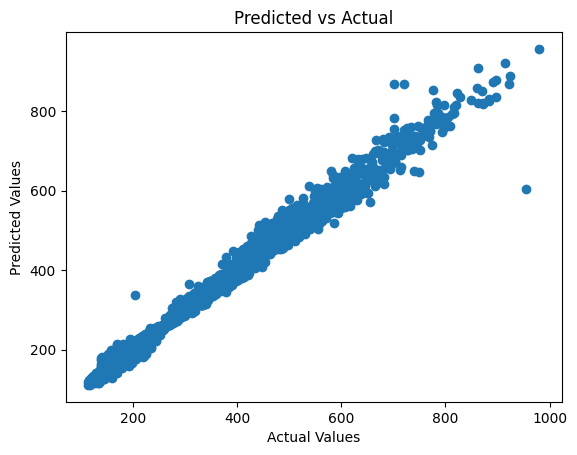

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predict using the trained model
y_pred = model.predict(X_val).flatten()

# Calculate the relative error and MRE (Median Relative Error)
relative_errors = np.abs((y_val - y_pred) / y_val)
mre = np.mean(relative_errors)
mdre = np.median(relative_errors)
# Calculate MSE, RMSE, and R^2
mse_val = mean_squared_error(y_val, y_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred)

# Calculate MAE (Mean Absolute Error)
mae_val = mean_absolute_error(y_val, y_pred)

# Calculate MDAE (Median Absolute Error)
mdae_val = np.median(np.abs(y_val - y_pred))

# Print metrics
print(f"Validation Set Mean Squared Error: {mse_val}")
print(f"Validation Set Root Mean Squared Error: {rmse_val}")
print(f"Validation Set R^2 Score: {r2_val}")
print(f"Validation Set Mean Relative Error: {mre}")
print(f"Validation Set Mean Absolute Error: {mae_val}")
print(f"Validation Set Median Absolute Error: {mdae_val}")
print(f"Validation Set Median Relative Error: {mdre}")

# Optional: Plot Predicted vs. Actual
plt.scatter(y_val, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.show()
